In [1]:
from utils import show_task_activation, plot_fmap
from utils import process_gray_matter_mask, create_4d_volume, create_events_df, compute_task_fmap, compute_bins_threshold
from utils import subject_gm_mask_path, paradigm_dir, subject_task_active_mask_path, subject_task_regressor_path, subject_task_sample_prefix
from utils import mkdir_no_exist, x_coords, y_coords, z_coords
# from viz import plot_voxel_timecourse

import os
from os.path import join as pjoin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from glob import glob

import nibabel as nib
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, run_glm
from nilearn.plotting import (
    plot_design_matrix,
    plot_stat_map,
    plot_img,
    plot_glass_brain,
)

In [2]:
subject = "127630"
task = "MOTOR"
acquisition = "RL"
smoothing = 10
TR = 0.72 

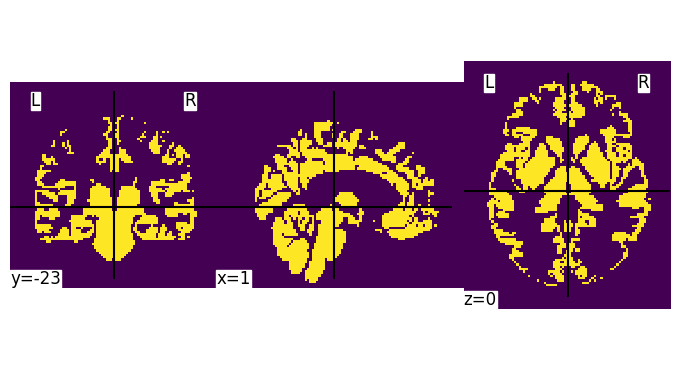

In [107]:
brain_mask = nib.load(f'./data/derivatives/anat/{subject}_gm_mask.nii.gz')
plot_img(brain_mask)

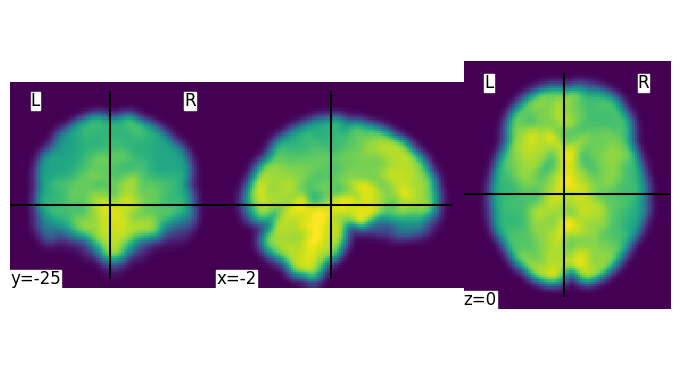

In [9]:
func_img = nib.load(f'./data/derivatives/func/{subject}_{task}_{acquisition}_smooth-{smoothing}mm_fMRIvols.nii.gz')
plot_img(image.mean_img(func_img))

In [13]:
events = pd.read_csv(f'./data/events/{subject}_{task}_{acquisition}_event.csv')
print(events)

    onset  duration     trial_type
0   10.80     11.52  condition_4_0
1   25.92     11.52  condition_2_1
2   56.16     11.52  condition_5_2
3   71.28     11.52  condition_1_3
4   86.40     11.52  condition_3_4
5  115.92     11.52  condition_4_5
6  131.04     12.24  condition_5_6
7  146.88     11.52  condition_2_7
8  162.00     11.52  condition_3_8
9  177.12     11.52  condition_1_9


In [14]:
fmri_glm = FirstLevelModel(
    mask_img=brain_mask,
    t_r=TR,
    noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    drift_model=None,
    minimize_memory=False,
)

fitted_glm = fmri_glm.fit(func_img, events)

(284, 10)

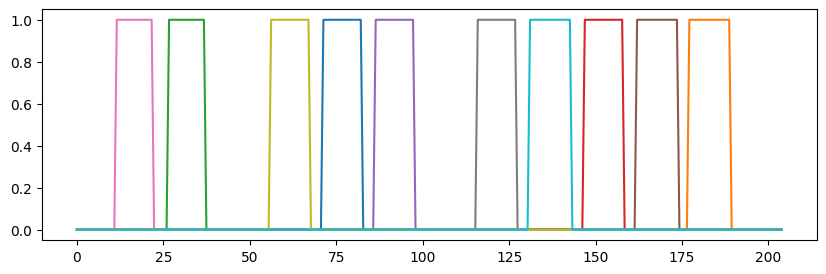

In [15]:
design_matrix = create_design_matrix(events, TR, func_img.shape[-1])
plt.figure(figsize=(10, 3))
plt.plot(design_matrix);
design_matrix.shape

design_matrix.shape

In [19]:
contrast_matrix = np.eye(design_matrix.shape[1], design_matrix.shape[1] + 1)
betas_data = fitted_glm.compute_contrast(contrast_matrix, output_type='effect_size')

In [20]:
f_test_result = fmri_glm.compute_contrast(contrast_matrix, stat_type="F", output_type="stat")

In [83]:
mask = f_test_result.get_fdata() > 5.839762417020578 # np.ones_like(f_test_result) == 1 

In [84]:
def create_design_matrix(events_df, tr, n_volumes):
    time_points = np.arange(0, n_volumes * tr, tr)
    
    conditions = sorted(events_df['trial_type'].unique())
    
    design_matrix = pd.DataFrame(0, index=time_points, columns=conditions)
    
    for _, event in events_df.iterrows():
        start_idx = np.searchsorted(time_points, event['onset'])
        end_idx = np.searchsorted(time_points, event['onset'] + event['duration'])
        design_matrix.iloc[start_idx:end_idx, conditions.index(event['trial_type'])] = 1
    
    return design_matrix

create_design_matrix(events, TR, func_img.shape[-1]);

In [85]:
voxel_betas = betas_data.get_fdata()[mask].reshape(-1, betas_data.shape[-1])

In [86]:
design_matrix

,condition_1_3,condition_1_9,condition_2_1,condition_2_7,condition_3_4,condition_3_8,condition_4_0,condition_4_5,condition_5_2,condition_5_6
0.00,0,0,0,0,0,0,0,0,0,0
0.72,0,0,0,0,0,0,0,0,0,0
1.44,0,0,0,0,0,0,0,0,0,0
2.16,0,0,0,0,0,0,0,0,0,0
2.88,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
200.88,0,0,0,0,0,0,0,0,0,0
201.60,0,0,0,0,0,0,0,0,0,0
202.32,0,0,0,0,0,0,0,0,0,0
203.04,0,0,0,0,0,0,0,0,0,0


In [87]:
voxel_betas.shape

(1939, 10)

In [88]:
design_matrix.shape

(284, 10)

In [89]:
block_like = voxel_betas @ design_matrix.T.to_numpy()

In [90]:
block_like.shape

(1939, 284)

In [91]:
predicted = fmri_glm.predicted[0].get_fdata()[mask]
predicted_data = predicted.reshape(-1, predicted.shape[-1])

In [92]:
predicted_data.shape

(1939, 284)

In [93]:
def match_amplitude_range(signal1, signal2):
    amp_range1 = np.max(signal1) - np.min(signal1)
    amp_range2 = np.max(signal2) - np.min(signal2)
    scale_factor = amp_range2 / amp_range1
    return signal1 * scale_factor, signal2

1939


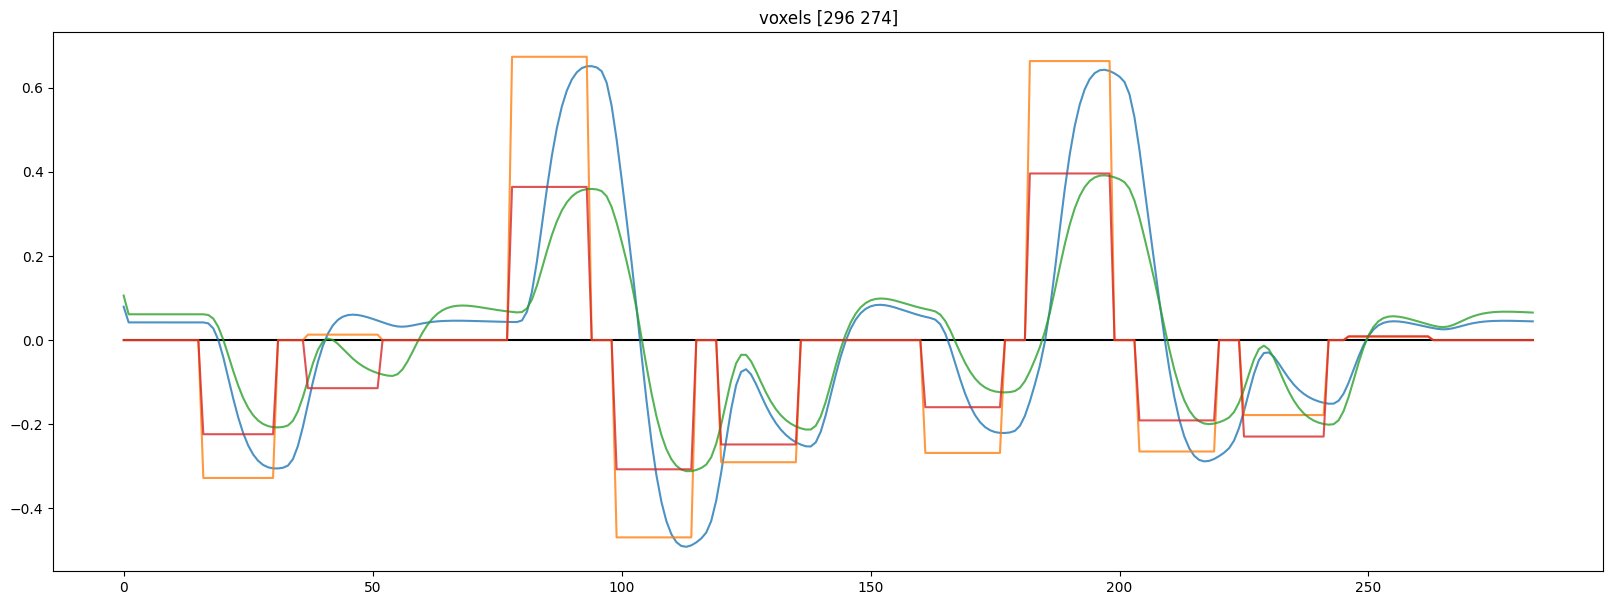

<Figure size 640x480 with 0 Axes>

In [104]:
pick = 2 #len(predicted_data)
print(len(predicted_data))

rand_picked_voxels = np.random.choice(np.arange(0, predicted_data.shape[0]), pick, replace=False)
# rand_voxels = np.append(rand_picked_voxels, np.array([272937, 331160]))
# rand_voxels = np.array([272937, 331160])
rand_voxels = rand_picked_voxels

plt.figure(figsize=(20, 7))
plt.title(f"voxels {rand_voxels}")
plt.plot(np.zeros_like(block_like[0, :]), c='k')
for voxel_idx in rand_voxels:
    block, bold = match_amplitude_range(block_like[voxel_idx, :], predicted_data[voxel_idx, :])
    
    plt.plot(bold, label=f"bold denoised {voxel_idx}", alpha=0.8)
    plt.plot(block, label=f"block like {voxel_idx}", alpha=0.8)

#plt.legend()
plt.show()
plt.tight_layout()

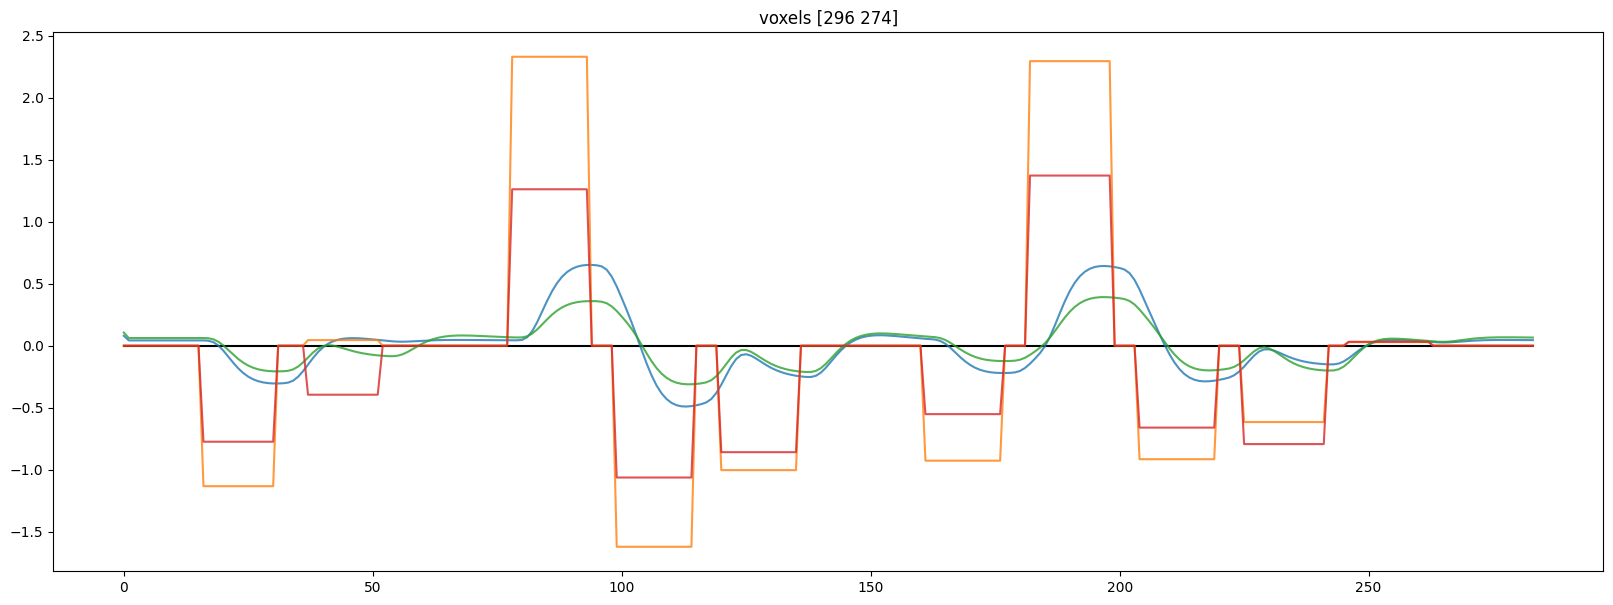

<Figure size 640x480 with 0 Axes>

In [105]:
plt.figure(figsize=(20, 7))
plt.title(f"voxels {rand_voxels}")
plt.plot(np.zeros_like(block_like[0, :]), c='k')
for voxel_idx in rand_voxels:
    block, bold = block_like[voxel_idx, :], predicted_data[voxel_idx, :]

    plt.plot(bold, label=f"bold denoised {voxel_idx}", alpha=0.8)
    plt.plot(block, label=f"block like {voxel_idx}", alpha=0.8)

#plt.legend()
plt.show()
plt.tight_layout()